**Import Libraries**

In [5]:
# Standard Libraries
import os
import random
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Progress Bar
from tqdm import tqdm

# Image processing libraries
import pydicom

# Machine Learning Libraries
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

**Define Parameters**

In [6]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/vinbigdata-chest-xray-abnormalities-detection-extracted'

# Disease labels
disease_labels = [
    "Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly",
    "Consolidation", "ILD", "Infiltration", "Lung Opacity",
    "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
    "Pneumothorax", "Pulmonary fibrosis"
]

# Parameters training
BATCH_SIZE = 8
EPOCHS = 1

# Define parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [7]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [8]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract VinDr-CXR dataset
extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [ ]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Map images to their full path
    labels_df['Path'] = labels_df['image_id'].map(lambda x: os.path.join(extracted_path, 'train', f"{x}.dicom"))

    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'train.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Change No Findings to class_id = 0**

In [ ]:
# FasterRCNN handles class_id = 0 as the background.
df["class_id"] = df["class_id"] + 1
df.loc[df["class_id"] == 15, ["class_id"]] = 0

**Fill Nan values**

In [ ]:
df.fillna(0, inplace=True)
df.loc[df["class_id"] == 0, ['x_max', 'y_max']] = 1.0

In [ ]:
print("df Shape: "+str(df.shape))
print("No Of Classes: "+str(df["class_id"].nunique()))

df Shape: (67914, 9)
No Of Classes: 15


In [ ]:
df.head(20)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,0.0,0.0,1.0,1.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,0.0,0.0,1.0,1.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,0.0,0.0,1.0,1.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,12,R9,627.0,357.0,947.0,433.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,6,R17,1347.0,245.0,2188.0,2169.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,9,R9,557.0,2352.0,675.0,2484.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,1,R10,1329.0,743.0,1521.0,958.0,/cluster/home/bjorneme/projects/Data/vinbigdat...
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,14,R9,1857.0,1607.0,2126.0,2036.0,/cluster/home/bjorneme/projects/Data/vinbigdat...


**Split Dataset**

In [ ]:
# Split based on patients
unique_patients = df['image_id'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['image_id'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['image_id'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['image_id'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 47573
Validation size: 6797
Test size: 13544


**Define Dataset for Chest X-ray images**

In [ ]:
class VinDrCXRDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Get the row corresponding to the image
        row = self.df.iloc[idx]

        img_path = row['Path']

        # Read the DICOM file
        ds = pydicom.dcmread(img_path)
        img = ds.pixel_array.astype(np.float32)
        orig_h, orig_w = img.shape
        
        # Normalize the image to range [0, 1]
        img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)

        # Transform image
        image = self.transform(img)
        
        scale_x = 640.0 / orig_w
        scale_y = 640.0 / orig_h

        # Then scale your box
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        x_min, x_max = x_min * scale_x, x_max * scale_x
        y_min, y_max = y_min * scale_y, y_max * scale_y

        boxes = torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32)
        labels = torch.tensor([row['class_id']], dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }
        
        return image, target


**Define Data Transformations**

In [ ]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 640x640
    transforms.Resize((640,640)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 640x640
    transforms.Resize((640,640)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [ ]:
train_dataset = VinDrCXRDataset(train_df, transform=train_transforms)
val_dataset = VinDrCXRDataset(val_df, transform=test_transforms)
test_dataset = VinDrCXRDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [ ]:
def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356624..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4671633..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


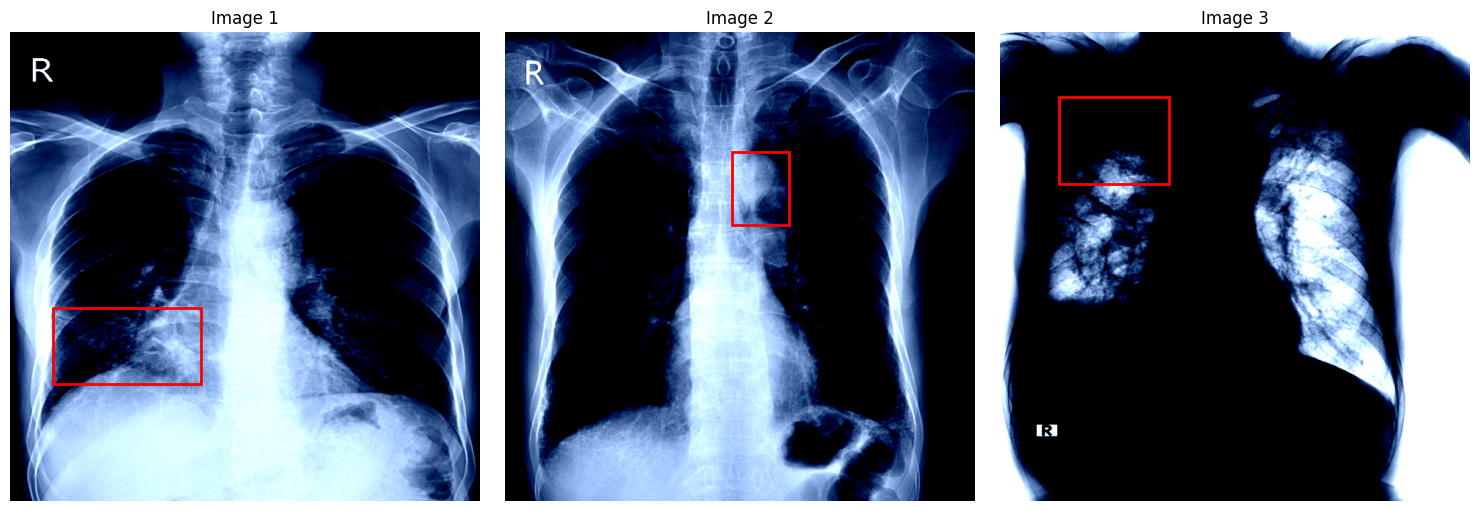

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Get one batch from the train_loader
images, targets = next(iter(train_loader))

# Create a figure with 3 subplots (one per image)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    # Get the i-th image and target
    img = images[i]
    target = targets[i]

    # If the image is a single-channel image, remove the channel dimension
    if img.shape[0] == 1:
        img = img.squeeze(0)
        axs[i].imshow(img.numpy(), cmap='gray')
    else:
        # Otherwise, assume the image is in (C, H, W) format and rearrange to (H, W, C)
        img = img.permute(1, 2, 0)
        axs[i].imshow(img.numpy())

    # Draw each bounding box on the image
    for box in target["boxes"]:
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        axs[i].add_patch(rect)

    axs[i].set_title(f"Image {i+1}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

# **Step 3: Build the Model**

In [ ]:
# Load a pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Adjust for number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(disease_labels)+1)
model.to(device)

/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# **Step 4: Train the Model**

In [ ]:
# Set up optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **Step 5: Evaluate the Model**

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# ----- Training Loop -----
for epoch in range(EPOCHS):

    model.train()
    train_loss = 0
    val_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for images, targets in progress_bar:

        # Move images and targets to the device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        progress_bar.set_postfix({"Loss": losses.item()})

    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    map_metric = MeanAveragePrecision(iou_thresholds=[0.5])
    model.eval()
    with torch.no_grad():
        for image, target in progress_bar:

            # Move images and targets to the device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Compute predictions for mAP
            predictions = model(images)

            print("Predictions:")
            print(predictions)

            map_metric.update(predictions, targets)

            # Compute loss
            model.train()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()
            results = map_metric.compute()
            progress_bar.set_postfix({"Loss": losses.item()})

            # Change back to eval for next iteration
            model.eval()

    print(f"Epoch {epoch+1}/{EPOCHS} | Training Loss: {train_loss/len(train_loader):.4f} | "
              f"Validation Loss: {val_loss/(val_loader):.4f}")

    # Compute the final metrics.
    results = map_metric.compute()
    print("mAP@0.5:", results['map'])

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/1:   3%|▎         | 169/5947 [01:02<35:29,  2.71it/s, Loss=0.14]   


ValueError: Caught ValueError in DataLoader worker process 9.
Original Traceback (most recent call last):
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_1798135/653343776.py", line 18, in __getitem__
    img = ds.pixel_array.astype(np.float32)
          ^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/dataset.py", line 2193, in pixel_array
    self.convert_pixel_data()
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/dataset.py", line 1726, in convert_pixel_data
    self._pixel_array = pixel_array(self, **opts)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/pixels/utils.py", line 1430, in pixel_array
    return decoder.as_array(
           ^^^^^^^^^^^^^^^^^
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/pixels/decoders/base.py", line 990, in as_array
    runner.validate()
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/pixels/decoders/base.py", line 755, in validate
    self._validate_buffer()
  File "/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/pydicom/pixels/decoders/base.py", line 778, in _validate_buffer
    raise ValueError(
ValueError: The number of bytes of pixel data is less than expected (4193824 vs 13249792 bytes) - the dataset may be corrupted, have an invalid group 0028 element value, or the transfer syntax may be incorrect
